# Simple DNN
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
%matplotlib inline

plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

### データの読み込み

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# 画像を読み込んだ時の変換関数を作る
tfm = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0,), (1,)),
                         ])
# それぞれのデータと読み込み方を指定
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=tfm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=tfm)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=2)


### ネットワークを作る

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, 10)
        self.layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        
    def forward(self, x):
        x = x.view(-1, 28*28)   # バッチを除いて1次元化 
        for layer in self.layers:
            x = F.relu(layer(x))
        return x
    

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=10, bias=True)
)


### 損失関数と最適化手法の定義

In [4]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # 微分の"使い方"

### 学習する

1 epoch /  100 roop  loss: 1.576
1 epoch /  200 roop  loss: 0.880
1 epoch /  300 roop  loss: 0.774
1 epoch /  400 roop  loss: 0.710
1 epoch /  500 roop  loss: 0.704
1 epoch /  600 roop  loss: 0.654
2 epoch /  100 roop  loss: 0.638
2 epoch /  200 roop  loss: 0.618
2 epoch /  300 roop  loss: 0.609
2 epoch /  400 roop  loss: 0.603
2 epoch /  500 roop  loss: 0.610
2 epoch /  600 roop  loss: 0.598
3 epoch /  100 roop  loss: 0.574
3 epoch /  200 roop  loss: 0.570
3 epoch /  300 roop  loss: 0.572
3 epoch /  400 roop  loss: 0.577
3 epoch /  500 roop  loss: 0.420
3 epoch /  600 roop  loss: 0.321
4 epoch /  100 roop  loss: 0.308
4 epoch /  200 roop  loss: 0.302
4 epoch /  300 roop  loss: 0.293
4 epoch /  400 roop  loss: 0.303
4 epoch /  500 roop  loss: 0.307
4 epoch /  600 roop  loss: 0.302
5 epoch /  100 roop  loss: 0.276
5 epoch /  200 roop  loss: 0.282
5 epoch /  300 roop  loss: 0.271
5 epoch /  400 roop  loss: 0.293
5 epoch /  500 roop  loss: 0.281
5 epoch /  600 roop  loss: 0.296
Finished T

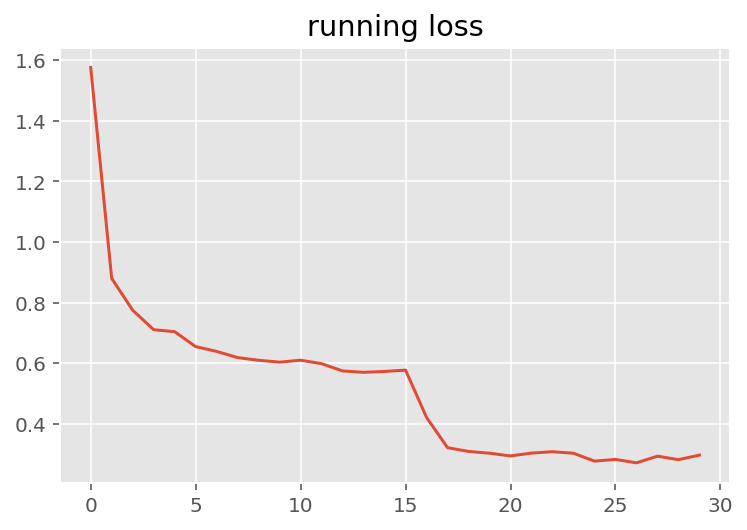

Wall time: 51.1 s


In [5]:
%%time
running_losses = list()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=1): 
        # get the inputs
        inputs, labels = data

        # 計算していた逆伝播を0に戻す
        optimizer.zero_grad()

        # forward / backward / optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # データを損失関数に突っ込む
        loss.backward()    # 誤差逆伝播(パラメータの変化の微分を計算)
        optimizer.step()   # 最適化手法をもとにパラメータ更新

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 100 mini-batches (1バッチは100枚 trainデータは60000枚あるので600までいく)
            running_loss_mean = running_loss / 100
            print('%d epoch /%5d roop  loss: %.3f' %
                  (epoch + 1, i, running_loss_mean))
            running_losses.append(running_loss_mean)
            running_loss = 0.0


print('Finished Training')

plt.plot(running_losses)
plt.title("running loss")
plt.show()

### 個別にテスト

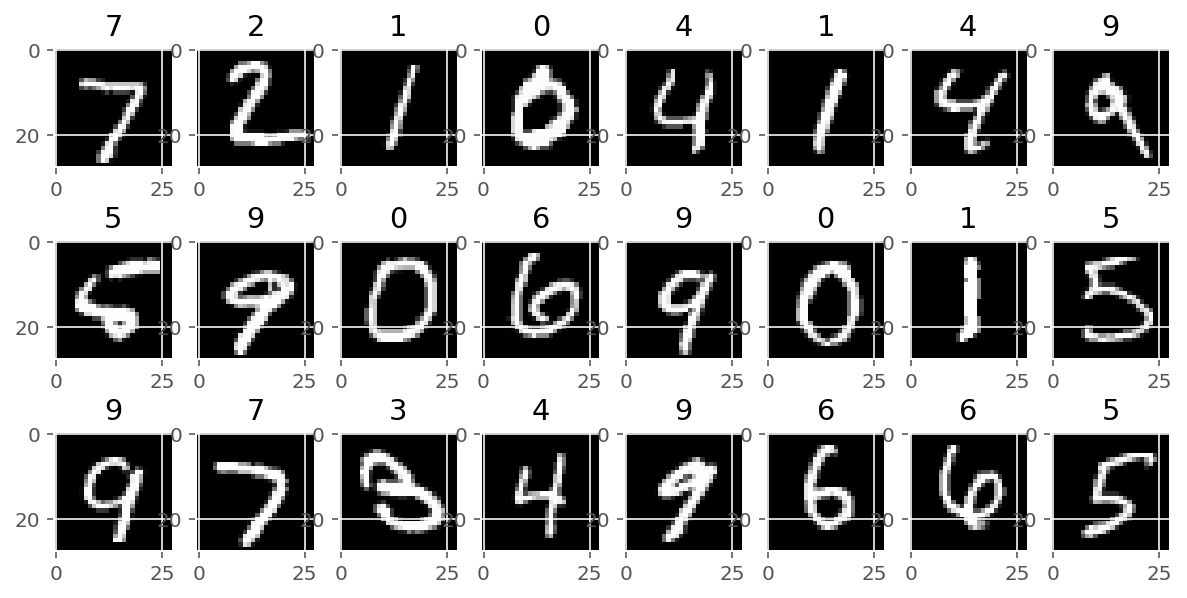

In [6]:
each_testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

dataiter = iter(each_testloader) 
plt.figure(figsize=(10,5))
for epoch in range(3*8):
    image, label = dataiter.next() # each_testloader はバッチサイズを１にしたので1枚ずつ出てくる
    output = net(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item() # tensor(pytorchでのデータ型)をpythonの数に直す
    image = image.reshape(28, 28) 
    label = label.item() 
    plt.subplot(3, 8, epoch+1)
    plt.imshow(image, cmap='gray')
    if predicted == label:
        plt.title(predicted, color='black')
    else:
        plt.title(predicted, color='red')
plt.show()


### 正解率を出す

In [7]:
correct = 0
total = 0
with torch.no_grad():  # 学習のときのようなバックグラウンドでの勾配計算は不要なのでしない
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %
